# 빈 공간 셈여림 추가하기
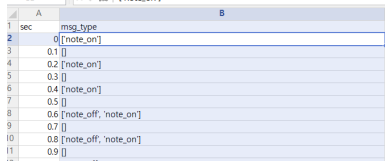

## 방법?
- 피아노 활성화 상태를 추적해 각각의 velocity에 따른 셈여림을 리스트로 만들어 추출한다.
    - 0.1초마다 셈여림 상태가 필요한가? -> 셈여림 변화 일관성을 측정하기 위해 필요함.
    - note_on 에 대한 셈여림 과, note_off에 대한 셈여림 추출이 필요해보임.
    

### 미디 데이터에 대한 -> 셈여림 리스트화 시키기

In [57]:
import pandas as pd

input_file = pd.read_csv('train_data0307.csv')
target_file = pd.read_csv('target_data0307.csv')

test_csv.head()

,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],ppp,0,0,100,0,0,0
1,0.1,"['note_on', 'note_on']","[0, 0]","[60, 60]","[21, 21]",ppp,0,2,0,0,0,0
2,0.2,[],[],[],[],NaN,0,0,0,0,0,0
3,0.3,"['note_on', 'note_on']","[0, 0]","[64, 64]","[32, 32]",ppp,0,2,0,0,0,0
4,0.4,[],[],[],[],NaN,0,0,0,0,0,0


1. 노트에 대해 리스트가 비었다면 -> x 표시, 만약 전 dynamic이 있다면, 그 값으로 넣어주기.

In [18]:
def distribute_dynamic(mean_velocity):
    """
    velocity에 따른 dynamic 기호 추출
    """
    dynamic = ''
    if 0 <= mean_velocity < 36:
        dynamic = 'ppp'
    elif 36 <= mean_velocity < 49:
        dynamic = 'pp'
    elif 49 <= mean_velocity < 62:
        dynamic = 'p'
    elif 62 <= mean_velocity < 75:
        dynamic = 'mp'
    elif 75 <= mean_velocity < 88:
        dynamic = 'mf'
    elif 88 <= mean_velocity < 101:
        dynamic = 'f'
    elif 101 <= mean_velocity < 114:
        dynamic = 'ff'
    elif 114 <= mean_velocity <= 127:
        dynamic = 'fff'
    
    return dynamic

In [64]:

def add_new_dynamic_to_dataframe(input_file, target_file):
    """
    비어있는 dynamic 기호를 추가한다.
    1. note_on에 대한 dynamic 기호만 반영함.
        - dynamic 추가 방법
        1. 피아노 0.1초마다 note_on_status 값을 추출한다.
        2. 0.1 초에 해당하는 note_on 항목 중 velocity의 최대 값에 기반해 기호를 추출함.
    """
    input_file_note_status = [[{'note': x}, {'status': False}, {'velocity' : 0}] for x in range(128)]
    target_file_note_status = [[{'note': x}, {'status': False}, {'velocity' : 0}] for x in range(128)]

    input_dynamic_list = []
    target_dynamic_list = []
    
    # 인풋 데이터에 대해서 수행.
    for index in range(len(input_file)):

            target_temp_data = []

            notes_input = eval(input_file.at[index, 'note']) # 문자열을 -> 숫자로
            msg_type_input = eval(input_file.at[index, 'msg_type']) # 문자열을 -> 숫자로
            velocity = eval(input_file.at[index, 'velocity'])

            temp = list(zip(notes_input, msg_type_input, velocity)) # [(60, 'note_on'), (60, 'note_on')] 이와 같이 데이터 수정

            # 피아노 활성화 값 추적 
            for data in temp:
                if data[1] == 'note_on':
                    input_file_note_status[data[0]][1]['status'] = True
                    input_file_note_status[data[0]][2]['velocity'] = data[2]
                elif data[1] == 'note_off':
                    input_file_note_status[data[0]][1]['status'] = False
                    input_file_note_status[data[0]][2]['velocity'] = data[2]

            velocity_list = []

            for on_data in input_file_note_status:
                if on_data[1]['status'] == True:
                    velocity_list.append(({'note': on_data[0]['note']}, {'velocity' : on_data[2]['velocity']}))

            max_velocity = 0 # 최대 값 찾기

            for velocity in velocity_list:
                # 최대값 찾기
                if max_velocity < velocity[1]['velocity']:
                    max_velocity = velocity[1]['velocity']
            dynamic = distribute_dynamic(max_velocity)
            input_dynamic_list.append(dynamic)
            
    
    # 타겟 데이터에 대해 수행
    for index in range(len(target_file)):


            notes_input = eval(target_file.at[index, 'note']) # 문자열을 -> 숫자로
            msg_type_input = eval(target_file.at[index, 'msg_type']) # 문자열을 -> 숫자로
            velocity = eval(target_file.at[index, 'velocity'])

            temp = list(zip(notes_input, msg_type_input, velocity)) # [(60, 'note_on'), (60, 'note_on')] 이와 같이 데이터 수정

            # 피아노 활성화 값 추적 
            for data in temp:
                if data[1] == 'note_on':
                    target_file_note_status[data[0]][1]['status'] = True
                    target_file_note_status[data[0]][2]['velocity'] = data[2]
                elif data[1] == 'note_off':
                    target_file_note_status[data[0]][1]['status'] = False
                    target_file_note_status[data[0]][2]['velocity'] = data[2]

            velocity_list = []

            for on_data in target_file_note_status:
                if on_data[1]['status'] == True:
                    velocity_list.append(({'note': on_data[0]['note']}, {'velocity' : on_data[2]['velocity']}))

            max_velocity = 0 # 최대 값 찾기

            for velocity in velocity_list:
                # 최대값 찾기
                if max_velocity < velocity[1]['velocity']:
                    max_velocity = velocity[1]['velocity']
            dynamic = distribute_dynamic(max_velocity)
            target_dynamic_list.append(dynamic)


    target_file.insert(loc=5, column='new_dynamic', value=target_dynamic_list)
    input_file.insert(loc=5, column='new_dynamic', value=input_dynamic_list)

In [65]:
add_new_dynamic_to_dataframe(input_file, target_file)

In [66]:
input_file.head()

,sec,msg_type,channel,note,velocity,new_dynamic,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],ppp,ppp,0,0,100,0,0,0
1,0.1,"['note_on', 'note_on']","[0, 0]","[60, 60]","[21, 21]",ppp,ppp,0,2,0,0,0,0
2,0.2,[],[],[],[],ppp,NaN,0,0,0,0,0,0
3,0.3,"['note_on', 'note_on']","[0, 0]","[64, 64]","[32, 32]",ppp,ppp,0,2,0,0,0,0
4,0.4,[],[],[],[],ppp,NaN,0,0,0,0,0,0


In [67]:
target_file.head()

,sec,msg_type,channel,note,velocity,new_dynamic,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,['note_on'],[0],[60],[61],p,p,0,1,"[100, 100, 100]","[127, 127]",127,"[64, 64]"
1,0.1,[],[],[],[],p,NaN,0,0,0,0,0,0
2,0.2,['note_on'],[0],[64],[57],p,p,0,1,0,0,0,0
3,0.3,[],[],[],[],p,NaN,0,0,0,0,0,0
4,0.4,['note_on'],[0],[67],[56],p,p,0,1,0,0,0,0
